# Sample RPGF3 List ✨

### Note: this list is just for fun and not a real funding recommendation!

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd
from scripts.oso_db import execute_query, execute_saved_query

In [2]:
app_data_path = "data/2023-10-28_RPGF3_cleaned_applicant_data.json"
with open(app_data_path) as j:
    app_data = json.load(j)

In [3]:
oss_apps = [p for p in app_data if p['Slug: Payout Address']]
df = pd.DataFrame(oss_apps)
df.drop_duplicates(subset=['Link'], keep='last', inplace=True)
print(f"Analysis includes {len(df)} OSS projects.")

Analysis includes 341 OSS projects.


In [4]:
slugs = list(set([p['Slug: Payout Address'].lower() for p in oss_apps]))
print(f"... and {len(slugs)} unique slugs.")

... and 324 unique slugs.


In [9]:
# Check if any projects have duplicate slugs (and need closer review)

to_review = df['Slug: Payout Address'].value_counts()
to_review = to_review[to_review>1]
(
    df[df['Slug: Payout Address']
       .isin(to_review.index)]
    .sort_values(by='Slug: Payout Address')
    [['Project Name', 'Slug: Payout Address', 'Payout Address']]
)

,Project Name,Slug: Payout Address,Payout Address
115,ERC1155 Bridge,bootnodedev,0x6b10D7Fc3774431aDD486265a9049e4c9b7eFE5B
144,Bedrock Contracts Architecture Diagram,bootnodedev,0x6b10D7Fc3774431aDD486265a9049e4c9b7eFE5B
238,Randomness Ceremony,filosofiacodigo,0xFe568475CFc25563B5A5E9769f56b61dF85e7Dec
127,FilosofiaCodigo,filosofiacodigo,0xb6F5414bAb8d5ad8F33E37591C02f7284E974FcB
40,ITU Blockchain,itu-blockchain,0xBEC643BD5b7F5e9190617CA4187ef0455950C51C
139,Clave (formerly Opclave),itu-blockchain,0x3E2e8E11c307830b358959F27128de4E93AC9FA4
6,LXDAO,lxdao-official,0xC3d7F926e57Ff06e465823b100b95408e805DfA2
33,MyFirstLayer2,lxdao-official,0xAcb4313910574b69e8116617105b97993ED8319d
232,Donate3,lxdao-official,0xb15115A15d5992A756D003AE74C0b832918fAb75
191,EIP Fun,lxdao-official,0xEe972E35311F65e6fD8F6ea7228Bf388B53e1D4a


In [12]:
slugs_to_ids = df.set_index('Slug: Payout Address')['Project ID'].to_dict()

## Query: get the first 69 stars from all OSS projects in RPGF3

In [13]:
slugs_list = "','".join(slugs)
stopper = 69
query = f"""
    WITH RankedEvents AS (
        SELECT
            e.time,
            p.slug,
            ROW_NUMBER() OVER (PARTITION BY p.slug ORDER BY e.time) AS row_num
        FROM
            event e
        LEFT JOIN
            project_artifacts_artifact paa ON e."toId" = paa."artifactId"
        LEFT JOIN
            project p ON paa."projectId" = p."id"
        WHERE
            p.slug IN ('{slugs_list}')
            AND e."typeId" = 21
    )
    SELECT
        time,
        slug
    FROM
        RankedEvents
    WHERE
        row_num <= {stopper}
    ORDER BY
        slug,
        time;
"""
results = execute_query(query, col_names=False)

In [14]:
project_dates = defaultdict(list)

for date_str, project in results:
    project_dates[project].append(date_str)

project_ages = {}

for project, dates in project_dates.items():
    if len(dates) >= stopper:
        project_ages[project] = (datetime.now().timestamp() - dates[stopper-1].timestamp()) / (60*60*24)
    else:
        project_ages[project] = 0

## View results and export a list

In [27]:
def listify(lst, amount):
    total = sum(project_ages.values())
    factor = amount / total
    new_list = {k:round(v*factor,2) for k,v in project_ages.items() if v>0}
    new_list = dict(sorted(new_list.items(), key = lambda x: x[1], reverse=True))
    return new_list

named_list = listify(project_ages, 30000000)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

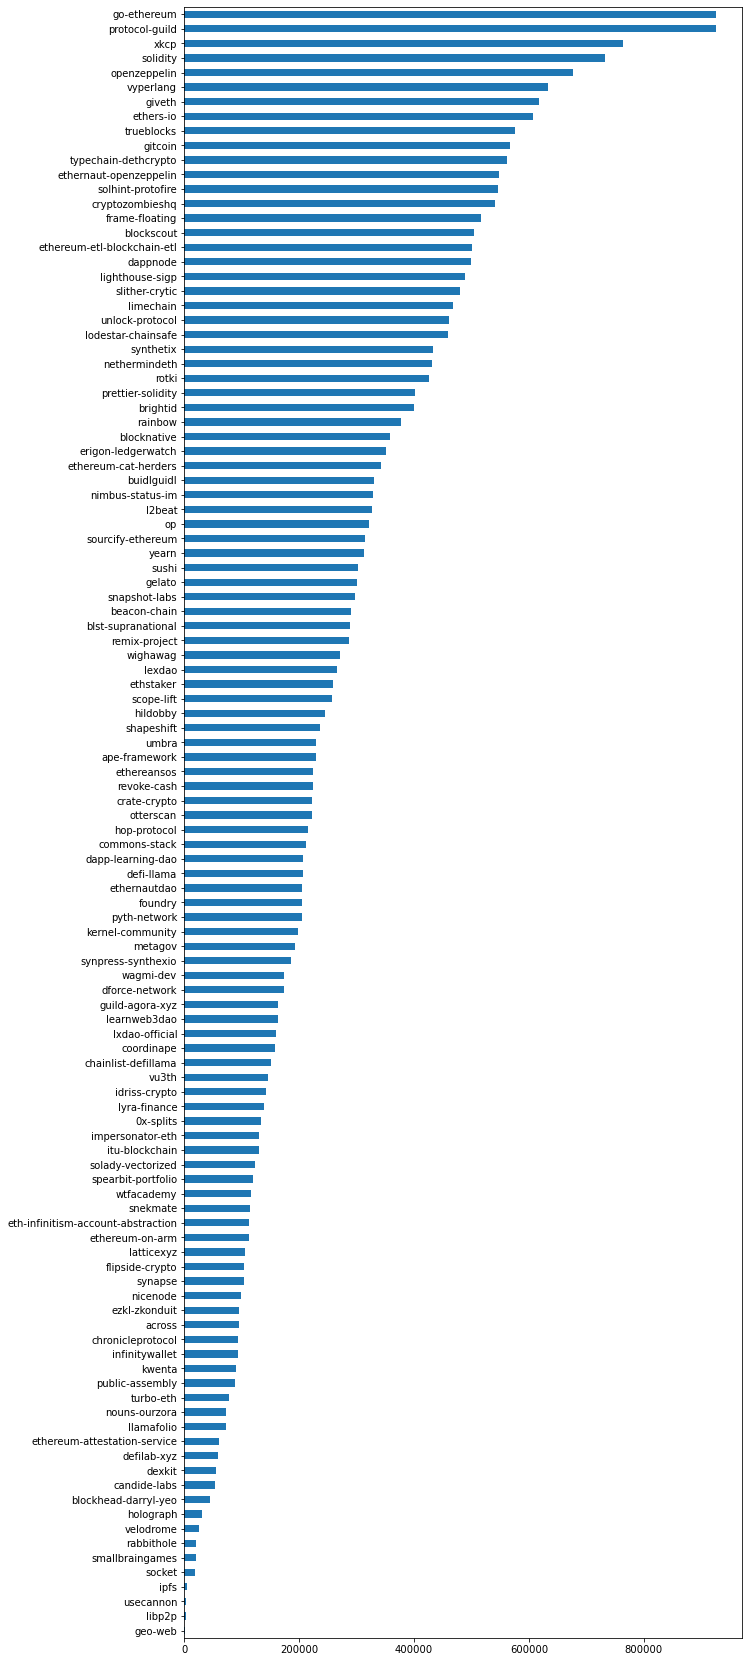

In [29]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,30))

In [34]:
# https://optimism.easscan.org/schema/view/0x3e3e2172aebb902cf7aa6e1820809c5b469af139e7a4265442b1c22b97c6b2a5

def create_eas_json(allocation_dict, list_name, list_link, list_descr, list_categories):
    return {
        'listDescription': list_name,
        'impactEvaluationLink': list_link,
        'impactEvaluationDescription': list_descr,
        'impactCategory': list_categories,
        'listContent': [
            {'RPGF3_Application_UID': k, 'OPAmount': v} for k,v in allocation_dict.items()
        ]
    }

eas_metadata = create_eas_json(
    allocation_dict=rpgf_list,
    list_name="Star69",
    list_link="https://github.com/opensource-observer/insights/blob/main/notebooks/2023-10-29_ListStar69.ipynb",
    list_descr="This list only considers projects with open source GitHub repos that have received more than 69 stars. The list identifies when the project received its 69th star and allocates OP Tokens based on how many days it's been since then. In other words, it favors popular, older OSS projects over newer and/or less popular OSS projects.",
    list_categories=['DEVELOPER_ECOSYSTEM', 'END_USER_EXPERIENCE_AND_ADOPTION', 'OP_STACK']
)

In [33]:
with open("data/Star69_Metadata.json", "w") as f:
    json.dump(eas_metadata, f, indent=4)